# Optimizing with gradient descent

Our neural network framework is almost complete. The `Scalar` class has almost everything we need. The one thing left to do is to implement gradient descent.

Let's recap: our ultimate goal is to find the minima of the loss function $ L $, describing how well the model fits the data. Analytic solutions are rarely possible in optimization theory, so quite often, the best option is (some variant of) gradient descent. According to theory, if the starting point $ x^{(0)} $ and the learning rate $ h $ is <strike>luckily</strike> properly selected, the sequence

$$
x^{(n + 1)} = x^{(n)} - h f^\prime(x^{(n)})
$$ (eq:computational-graphs/gradient-descent/gradient-update)

converges to a local minimum. I know, it feels like black magic, but it works.

So far, here's our training loop.

```
# -- inputs --
# model: the machine learning model
# xs: training data
# ys: the ground truth
# n_epochs: the number of iterations
# lr: learning rate

for _ in range(n_epochs):
 ys_pred = [model(x) for x in xs]
 loss = loss_function(ys, ys_pred)

 loss.backward()

 for p in model.parameters:
 p.gradient_update(lr)
```

Two things are missing from our DIY computational graph framework: the loss function and the gradient update method. Let's get started.

## Loss functions

To train a predictive model, we need to measure how well it fits the data. This is done by the a loss function $ L(\mathbf{y}_1, \dots, \mathbf{y}_N, \widehat{y}_1, \dots, \widehat{y}_N) $, where

* $ \mathbf{x} = (x_1, \dots, x_N) $ are the training samples (which can be high dimensional vectors as well),
* $ \mathbf{y} = (y_1, \dots, y_N) $ are the corresponding labels,
* $ f $ is our machine learning model,
* and $ \widehat{y}_i $ $ \widehat{\mathbf{y}} = (\widehat{y}_1, \dots, \widehat{y}_N) $ are our predictions.

For example, the *mean squared error*

$$
\mathrm{MSE}(\widehat{\mathbf{y}}, \mathbf{y}) = \frac{1}{N} \sum_{i=1}^{N} (\widehat{y}_i - y_i)^2
$$

is for regression problems (i.e. when $ y_i \in \mathbb{R} $), while the *binary cross-entropy*

$$
\mathrm{H}(\widehat{\mathbf{y}}, \mathbf{y}) = \frac{1}{N} \sum_{i=1}^{N} y_i \log \widehat{y}_i 
$$

is for binary classification problems (i.e. when $ y_i \in \{ 0, 1 \}) $.

We'll go with the mean squared error first. Its implementation is quite easy:

In [1]:
from typing import List


def mean_squared_error(preds: List, ys: List):
    return sum([(p - y) ** 2 for p, y in zip(preds, ys)]) / len(preds)

Let's generate some data and try a linear model.

In [2]:
from random import random, normalvariate


xs = [random() for _ in range(100)]
ys = [0.8*x - 1.2 + normalvariate(0, 0.1) for x in xs]

Here's how it looks, in case you are wondering. (It is similar to the dataset we've used to {ref}`illustrate the high-level interface <chapter:computational-graphs/model>` of `Scalars`.)

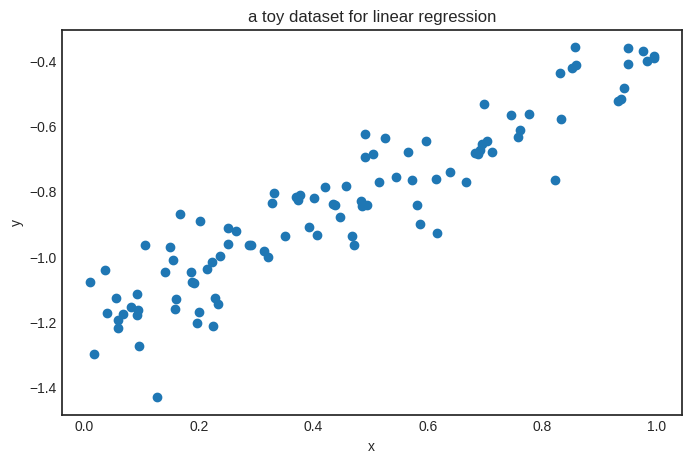

In [3]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))
    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('a toy dataset for linear regression')
    plt.show()

In [4]:
import math
from collections import namedtuple


Edge = namedtuple("Edge", ["prev", "local_grad"])


class Scalar:
    def __init__(self, value: float, prevs: List = None):
        self.value = value
        self.prevs = prevs if prevs is not None else []
        self.backwards_grad = 0

    def __repr__(self):
        return f"Scalar({self.value})"

    def _backward_step(self):
        for prev, local_grad in self.prevs:
            prev.backwards_grad += local_grad * self.backwards_grad

    def _get_graph(self, zero_grad=False):
        ordered_scalars = []
        visited_scalars = set()

        def traverse_graph(x):
            if x not in visited_scalars:
                visited_scalars.add(x)

                if zero_grad:
                    x.backwards_grad = 0

                for prev, _ in x.prevs:
                    traverse_graph(prev)

                ordered_scalars.append(x)

        traverse_graph(self)

        return ordered_scalars

    def _zero_grad(self):
        self._get_graph(zero_grad=True)

    def backward(self):
        ordered_scalars = self._get_graph(zero_grad=True)

        self.backwards_grad = 1

        for scalar in reversed(ordered_scalars):
            scalar._backward_step()

    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[Edge(self, 1), Edge(other, 1)],
        )

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value * other.value,
            prevs=[Edge(self, other.value), Edge(other, self.value)],
        )

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return (-1) * self

    def __truediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value / other.value,
            prevs=[
                Edge(self, 1 / other.value),
                Edge(other, -self.value / other.value**2),
            ],
        )

    def __rtruediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return other / self

    def __pow__(self, exponent):
        if not isinstance(exponent, Scalar):
            exponent = Scalar(exponent)

        return Scalar(
            value=self.value**exponent.value,
            prevs=[
                Edge(self, exponent.value * self.value ** (exponent.value - 1)),
                Edge(
                    exponent,
                    math.log(abs(self.value)) * (self.value**exponent.value),
                ),
            ],
        )


Let's define a model, create the predictions, and then calculate the loss.

In [5]:
a = Scalar(1)
b = Scalar(1)

def linear(x):
    return a * x + b

In [6]:
preds = [linear(x) for x in xs]
loss_fn = mean_squared_error(preds, ys)

In [7]:
loss_fn

Scalar(5.266608709846611)

As expected, the output of `mean_squared_error` is a `Scalar`; that is, it's part of our computational graph. Here it is in the case of $ N = 3 $. (We can further unravel the graph by expanding $ f(x_i) $, but we won't do that here.)

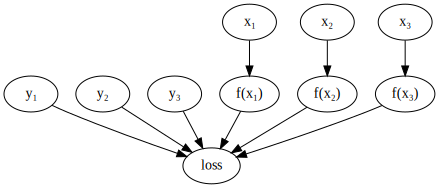

In [8]:
from graphviz import Digraph

digraph = Digraph()
nodes = ["y₁", "y₂", "y₃", "x₁", "x₂", "x₃", "f(x₁)", "f(x₂)", "f(x₃)", "loss"]
edges = [("y₁", "loss"), ("y₂", "loss"), ("y₃", "loss"),
         ("x₁", "f(x₁)"), ("x₂", "f(x₂)"), ("x₃", "f(x₃)"),
         ("f(x₁)", "loss"), ("f(x₂)", "loss"), ("f(x₃)", "loss")]

for v in nodes:
    digraph.node(v, v)

for u, v in edges:
    digraph.edge(u, v)

digraph


As `loss` is a fully functional `Scalar`, we can use backpropagation to calculate its derivative with respect to parameters.

In [9]:
loss_fn.backward()

In [10]:
a.backwards_grad

2.0709603248670883

What can we do with this derivative? Taking a gradient step, for instance.

## The gradient update

Based on {eq}`eq:computational-graphs/gradient-descent/gradient-update`, the gradient update method is quite simple to add.

In [11]:
class Scalar(Scalar):
    # ...

    def gradient_update(self, lr):
        self.value -= lr * self.backwards_grad

    # ...

Let's put this together and do the full training loop.

In [12]:
a = Scalar(1)
b = Scalar(1)


def linear(x):
    return a * x + b

In [13]:
n_epochs = 100
lr = 0.5

for _ in range(n_epochs):
    ys_pred = [linear(x) for x in xs]
    loss_fn = mean_squared_error(ys, ys_pred)

    loss_fn.backward()

    for p in [a, b]:
        p.gradient_update(lr)

The parameter `a` should be close to `0.8`, and `b` to `1.2`. Let's check!

In [14]:
f"a = {a}, b = {b}"

'a = Scalar(0.8163006575397458), b = Scalar(-1.2106053605729452)'

The training works!

If you are curious, this is how the model looks on the data.

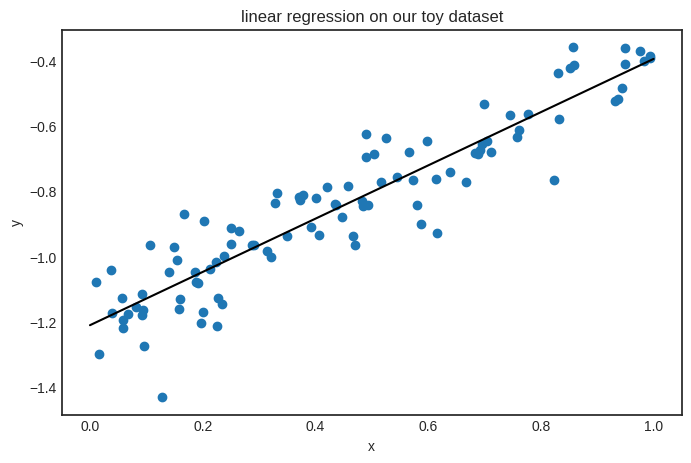

In [15]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))

    xs_plot = [0.01 * k for k in range(101)]
    ys_plot = [linear(x).value for x in xs_plot]
    plt.plot(xs_plot, ys_plot, c="k")

    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('linear regression on our toy dataset')
    plt.show()

Now, the functionality of `Scalar` is complete.

## Abstracting the training loop

Alright. Is there anything else left to do? My fellow OOP ninjas might have noticed several potential improvements to be made. For instance, take a look at the parameter update loop:

```
for p in [a, b]:
    p.gradient_update(lr)
```

Manually enumerating the parameters won't work for complex models such as multi-layer neural networks. Moreover, the entire training loop is a piece of reusable code! So, let's wrap things into utility classes!

### Models...

First, we'll focus on models. Up until this point, we've worked with Python functions like the linear model above:

In [16]:
a = Scalar(1)
b = Scalar(1)


def linear(x):
    return a * x + b

Let's move all the functionalities into the new `Model` class. We'll use Python's abstract base classes. ({ref}`Check out the official documentation if you are not familiar with them <https://docs.python.org/3/library/abc.html>`.)

In [17]:
from abc import ABC, abstractmethod


class Model(ABC):
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def gradient_update(self, lr):
        for _, p in self.parameters().items():
            p.gradient_update(lr)

    @abstractmethod
    def forward(self, *args, **kwargs):
        pass

    @abstractmethod
    def parameters(self):
        pass

    def load_parameters(self, params):
        for key, value in params.items():
            setattr(self, key, value)

As `Model` is an abstract base class, it is not instantiable; we have to subclass it and override the abstract methods `forward` and `parameters`. For instance, this is how our linear model looks in this framework.

In [18]:
class Linear(Model):
    def __init__(self):
        self.a = Scalar(1)
        self.b = Scalar(1)

    def forward(self, x: Scalar) -> Scalar:
        return self.a * x + self.b
    
    def parameters(self):
        return {"a": self.a, "b": self.b}

We did not solve the manual parameter listing problem; we just made it slightly more bearable. The ultimate solution will be introducing the `Tensor` class to replace `Scalar`, but that's way down the line.

In [19]:
model = Linear()

In [20]:
model(42)

Scalar(43)

In case we need to load a model from storage, we can use the `load_parameters` method.

In [21]:
model.load_parameters({"a": Scalar(-1), "b": Scalar(-1)})

In [22]:
f"a = {model.a}, b = {model.b}"

'a = Scalar(-1), b = Scalar(-1)'

### ...and optimizers

Besides the model-related functionalities, the core training loop of gradient descent can also be abstracted away. Later, when we study advanced optimization techniques (such as stochastic gradient descent or adaptive learning rates), this interface will prove quite useful.

Here is `GradientDescent`, packing the training loop into a single class.

In [23]:
class GradientDescent:
    def __init__(self, model, loss_fn):
        self.model = model
        self.loss_fn = loss_fn

    def run(self, xs, ys, lr: float = 0.01, n_steps: int = 1000):
        for _ in range(n_steps):
            preds = [self.model.forward(x) for x in xs]
            l = self.loss_fn(preds, ys)
            l.backward()
            self.model.gradient_update(lr)

Let's try it out!

In [24]:
model = Linear()
optimizer = GradientDescent(model, mean_squared_error)

In [25]:
optimizer.run(xs, ys, lr=0.01, n_steps=1000)

Let's make the very same plot we made a few cells above to see if it worked.

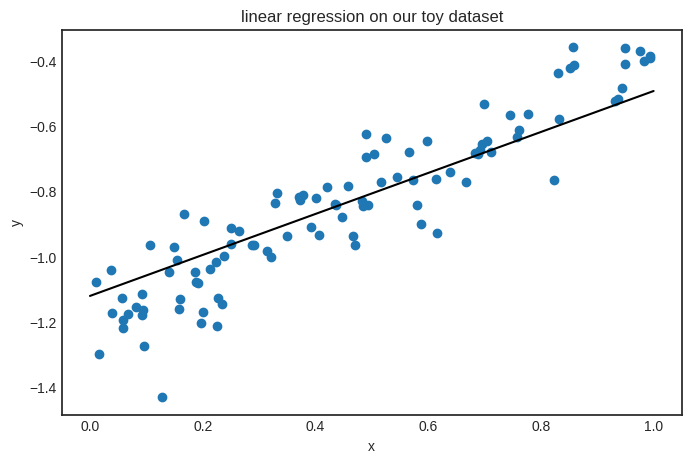

In [26]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))

    xs_plot = [0.01 * k for k in range(101)]
    ys_plot = [model(x).value for x in xs_plot]
    plt.plot(xs_plot, ys_plot, c="k")

    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('linear regression on our toy dataset')
    plt.show()